In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Data preprocessing for HCMC survey dataset"""

__author__ = "Anna Buch, Heidelberg University"
__email__ = "a.buch@stud.uni-heidelberg.de"

## Feature selection 
Enitre workflow with all models for the target variables relative content loss and business reduction (degree of loss) as well for the binary version of relative content loss (chance of loss)

Due to the samll sample size a nested CV is used to have the possibility to even get generalization error, in the inner CV the best hyperaparamters based on k-fold are selected; in the outer cv the generalization error across all tested models is evaluated. A seprate unseen validation set as done by train-test split would have an insufficent small sample size.
Nested CV is computationally intensive but with the samll sample size and a well chosen set of only most important hyperparameters this can be overcome.

- Logistic Regression (binrary rcloss)
- Elastic Net
- eXtreme Gradient Boosting
- Conditional Random Forest


In [2]:
import sys
from pathlib import Path
from glob import glob
import numpy as np
import pandas as pd

import pickle
import joblib

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold, RepeatedStratifiedKFold, RepeatedKFold, cross_validate, cross_val_predict
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error, PredictionErrorDisplay,  f1_score, confusion_matrix, mean_absolute_error
from sklearn.pipeline import Pipeline

from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

sys.path.insert(0, "../../../")
import utils.utils_feature_selection as fs
import utils.utils_evaluation as e
import utils.utils_figures as f
import utils.settings as s
import utils.pipelines as p
import utils.utils_processing as pp

p.main()  # create/update model settings
#s.init()
seed = s.seed

pd.set_option('display.max_columns', None)
plt.figure(figsize=(20, 10))

import warnings
warnings.filterwarnings('ignore')

targets = ["Target_relative_contentloss_euro", "Target_businessreduction"]
target = targets[0]


c:\Anaconda\envs\py396_c3\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


<Figure size 2000x1000 with 0 Axes>

#### Load R packages to process Conditional Random Forest in python
*Note 1: all needed R packages have to be previously loaded in R*

*Note 2: Make sure that caret package version >= 6.0-81, otherwise caret.train() throws an error*

In [3]:
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr, data
import rpy2.robjects.packages as rpackages


# get basic R packages
utils = importr('utils')
base = importr('base')
dplyr = importr('dplyr')
stats_r = importr("stats")  # rename due to similar python package

# pandas.DataFrames to R dataframes 
from rpy2.robjects import pandas2ri, Formula
pandas2ri.activate()

# print r df in html
import rpy2.ipython.html
rpy2.ipython.html.init_printing()


# get libraries for CRF processing, ctree_controls etc
partykit = importr('partykit') # for single Conditional Inference tree
party = importr('party')        # Random Forest with Conditional Inference Trees (Conditional Random Forest)
permimp = importr('permimp')  # conditional permutation feature importance
caret = importr('caret') # package version needs to be higher than  >=  6.0-90
nestedcv = importr('nestedcv')
#stablelearner = importr('stablelearner')
#ggplot2 = importr('ggplot2')


In [4]:
df_candidates = pd.read_excel("../../../input_survey_data/input_data_contentloss_tueb.xlsx")
#df_candidates = pd.read_excel("../../../input_survey_data/input_data_businessreduction_tueb.xlsx")

df_candidates = df_candidates.drop(["Target_contentloss_euro", "shp_content_value_euro"], axis=1)

print(df_candidates.shape)
df_candidates.tail(2)

(397, 32)


,Target_relative_contentloss_euro,inundation_duration_h,water_depth_cm,contaminations.0,flowvelocity,emergency_measures.1,emergency_measures.2,emergency_measures.3,emergency_measures.4,emergency_measures.7,emergency_measures.8,overall_problem_house,protect_valuables_impl,water_barriers_impl,pumping_equipment_impl,elevation_building_impl,resistant_material_building_impl,electricity_higher_impl,flood_protections_impl,flood_experience,elevation_building_height_cm,bage,b_area,hh_monthly_income_cat,shp_owner,shp_sector,shp_employees,shp_avgmonthly_sale_cat,resilience_govern_careing_increases,contaminations_light,contaminations_heavy,shp_registered_capital_euro
395,NaN,4.0,70.0,0,1,1,0,1,0,0,0,1,1,5,1,1,5,5,5,5,70.0,NaN,130.0,NaN,1,17,2,3,1.0,1,0,11047.7
396,NaN,3.0,100.0,0,1,1,0,1,0,0,0,0,1,5,5,5,5,5,5,4,NaN,5.0,33.0,1.0,1,11,2,3,NaN,1,0,736.5


In [5]:
## impl in data_cleaning
#print(df_candidates.floors.describe())
try: 
    df_candidates = df_candidates[df_candidates.floors < 3, : ]
except:
    pass

In [6]:
### TODO impl this cell in data_cleaning

try:
    #if target=="Target_relative_contentloss_euro": 
    df_candidates = df_candidates.drop("floors", axis=1 )  # remove if still in ds due that it's used for shp_content_value and relative content loss
    df_candidates = df_candidates.drop("buildingtype_moon", axis=1)  # remove due to 64 % missing values   
except:
    pass
try:
    df_candidates = df_candidates.drop("elevation_building_height_cm", axis=1)
    df_candidates = df_candidates.drop(["contaminations_light","contaminations_heavy"], axis=1)
    #df_candidates = df_candidates.drop("resilience_govern_careing_increases", axis=1)
except:
    pass


print(df_candidates.shape)
df_candidates.tail(2)

(397, 29)


,Target_relative_contentloss_euro,inundation_duration_h,water_depth_cm,contaminations.0,flowvelocity,emergency_measures.1,emergency_measures.2,emergency_measures.3,emergency_measures.4,emergency_measures.7,emergency_measures.8,overall_problem_house,protect_valuables_impl,water_barriers_impl,pumping_equipment_impl,elevation_building_impl,resistant_material_building_impl,electricity_higher_impl,flood_protections_impl,flood_experience,bage,b_area,hh_monthly_income_cat,shp_owner,shp_sector,shp_employees,shp_avgmonthly_sale_cat,resilience_govern_careing_increases,shp_registered_capital_euro
395,NaN,4.0,70.0,0,1,1,0,1,0,0,0,1,1,5,1,1,5,5,5,5,NaN,130.0,NaN,1,17,2,3,1.0,11047.7
396,NaN,3.0,100.0,0,1,1,0,1,0,0,0,0,1,5,5,5,5,5,5,4,5.0,33.0,1.0,1,11,2,3,NaN,736.5


### Test remove further features

In [7]:
## delete features with more than 10% missing values
print("Percentage of missing values per feature [%]\n", round(df_candidates.isna().mean().sort_values(ascending=False)[:15]  * 100), 2) 


Percentage of missing values per feature [%]
 Target_relative_contentloss_euro       18.0
resilience_govern_careing_increases    14.0
shp_registered_capital_euro            12.0
bage                                    7.0
hh_monthly_income_cat                   6.0
inundation_duration_h                   2.0
b_area                                  1.0
water_depth_cm                          0.0
contaminations.0                        0.0
electricity_higher_impl                 0.0
shp_avgmonthly_sale_cat                 0.0
shp_employees                           0.0
shp_sector                              0.0
shp_owner                               0.0
flood_experience                        0.0
dtype: float64 2


In [8]:
df_candidates = df_candidates.loc[:,df_candidates.filter(regex="^(?!resilience_*)").columns]
df_candidates = df_candidates.loc[:,df_candidates.filter(regex="^(?!perception_*)").columns]


## Fit model 

In [9]:
score_names_for_performance = {
    #"MAE": make_scorer(mean_absolute_error, greater_is_better=False),
    #"RMSE": make_scorer(e.mean_bias_error, greater_is_better=False),
    "neg_MAE": "neg_mean_absolute_error",
    "neg_RMSE": "neg_root_mean_squared_error",
    "MBE": make_scorer(e.mean_bias_error, greater_is_better=False),
    "R2": "r2",
    "SMAPE": make_scorer(e.symmetric_mean_absolute_percentage_error, greater_is_better=False)
}


In [14]:
## iterate over piplines. Each piplines contains precrosseing methods and several  classifier
pipelines = ["pipe_crf", "pipe_en", "pipe_xgb"] 
#pipelines = ["pipe_logreg"]  
#pipelines = ["pipe_logreg", "pipe_xgb", "pipe_en", "pipe_crf"]

eval_set_list = []
models_trained = {}
model_coef = {}
predicted_probabilities = {}
df_feature_importances = pd.DataFrame(index=df_candidates.drop(target, axis=1).columns.to_list())
models_scores = {}

## Load set of hyperparamters
hyperparams_set = pp.load_config("../../../utils/hyperparameter_sets.json")


for pipe_name in pipelines:

    model_name = pipe_name.split('_')[1]
    print( f"\nApplying {model_name} on {target}:")
 
    df_candidates_t = df_candidates

    if (target == "Target_relative_contentloss_euro") & (model_name != "logreg" ):
        print(f"Removing {df_candidates_t.loc[df_candidates_t[target]==0.0,:].shape[0]} zero loss records")
        df_candidates_t = df_candidates_t.loc[df_candidates_t[target]!=0.0,:]
        print(f"Keeping {df_candidates_t.shape} damage cases for model training and evaluation")

    ## drop samples where target is nan
    print(f"Dropping {df_candidates_t[f'{target}'].isna().sum()} records from entire dataset due that these values are nan in target variable")
    df_candidates_t = df_candidates_t[ ~df_candidates_t[f"{target}"].isna()]
    
    ## EN: drop samples where any value is nan
    if (model_name == "en") | (model_name == "crf"):
        df_candidates_t.dropna(inplace=True)

    print(
        "Using ", df_candidates_t.shape[0], " records, from those are ", 
            { (df_candidates_t[target][df_candidates_t[target]==0.0]).count() }, 
            f" cases with zero-loss or zero-reduction"
    )

    X_unscaled = df_candidates_t.drop(target, axis=1)  # remove  target from X
    y = df_candidates_t[target]
     
    ## normalize data 
    scaler_for_X = MinMaxScaler()
    X = scaler_for_X.fit_transform(X_unscaled)

    # ## save evaluation set for later usage in feature importance
    # eval_set =  pd.concat([y, X], axis=1) 
    # eval_set_list.append({pipe_name : eval_set})

    ## load pipe for non-transfomred model
    pipe = joblib.load(f'./pipelines/{pipe_name}.pkl')

    ## Hyperparmater and cv setting       
    param_grid = hyperparams_set[f"{model_name}_hyperparameters"]

    ## EN (test with bagging)
    # if model_name == "en":
    #     ## paramter names when bootstrapping mehtod is applied
    #     print("Testing Elastic Net with bagging")
    #     param_grid = { k.replace('model', 'bagging__estimator') : v for (k, v) in param_grid.items()}

    if model_name != "crf":

        ## define inner and outer cv
        cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=seed)

        ## inner cv with hyperparameter tuning
        model = RandomizedSearchCV(
            estimator= pipe,
            param_distributions=param_grid,
            cv=cv, 
            scoring= "neg_mean_absolute_error",
            ##"", #"neg_mean_squared_error",#"r2" #TODO classifcation: test also e.g "f1" or recall or "f1_micro", "neg_mean_absolute_error",
            refit=True,   
            random_state=seed
        )
        ## TODO check if fit() is needed for evaluation of outer cv
        model.fit(X, y)

        ## get coefficient of each predictor
        try: 
            model_coefs = model.best_estimator_.named_steps['model'].coef_
            model_intercept = model.best_estimator_.named_steps['model'].intercept_
            #model_pvalue = model.best_estimator_.named_steps['model'].coef_
            print(f"Intercept for {model_name}: {model_intercept}")
            model_coef[f"{model_name}"] = pd.DataFrame(zip(X_unscaled.columns, model_coefs), columns=['features', 'coef']) 
        except:
            pass

         # get generalization performance based on tuned model
        scores = cross_validate(   # allows specifying multiple metrics for evaluation comparated to cross_val_score
        #cross_val_score(
            model, 
            X, y, 
            # return_train_score=  # if True: more computanitonal expensive, gives scores of training sets
            scoring=score_names_for_performance,  # Strategy to evaluate the performance of the cross-validated model on the test set.
            cv=cv, 
            n_jobs=-1
        ) 
        print("outer CV: MAE: %.3f (%.3f)"%(scores["test_neg_MAE"].mean(), np.std(scores["test_neg_MAE"])))
        models_scores[f"{model_name}"] = scores ## store scores for FI weighting

        ## outer cv for predictions (n == sample number of entire dataset)
        y_pred = cross_val_predict(
            model, 
            X, y, 
            cv=10, # KFold without repeats to have for each sample one predicted value 
            method="predict"
        )
        ## store highest predicted probabilities and respective empirical values
        y_pred_max = np.take_along_axis(
            y_pred, 
            np.expand_dims(
                np.argmax(y_pred, axis=1), 
                axis=1
            ), 
            axis=1
        )
        predicted_probabilities[f"{model_name}"] = pd.DataFrame({"y_empirical": y, "y_predicted": y_pred_max})


        # if model_name =="xgb":
        #     ## Fit best model on training set
        #     print("Testing early stopping for XGB")
        #     model.fit(
        #         X, y,
        #         model__early_stopping_rounds=3,
        #         model__eval_metric="mae",
        #         model__eval_set=[(X, y)],
        #         model__verbose=False
        #     )
        # else:
        ## TODO check if fit() is needed for evaluation of outer cv
        # model.fit(X, y)

        ## store best trained model
        models_trained[f"trained_{model_name}"] = model
        

    if model_name == "crf":
        base.set_seed(seed)
 
        model = nestedcv.nestcv_train(
            y=y, 
            x=pd.DataFrame(X, columns=X_unscaled.columns),
            method="cforest",
            savePredictions="final",
            outer_train_predict=True,
            #tuneGrid=tg, #cv_cores=2,  # leads to random errors
            metric='MAE',#'RMSE',  # RMSE unit of target or use MAE due that more robust than RMSE further metrics options Rsquared, RMSE, MAE 
                # RMSE penalizes large gaps more harshly than MAE
            # maximize=True,
            # #na_action =  stats.na_pass,
            controls = #party.cforest_control( 
                party.cforest_unbiased(
                # only mtry gets tuned by grid
                mtry=2,  # mtry=0 =Bagging without random input var sampling
                ntree = 100,  # didnt improved with 200 or 500 trees
                # mincriterion = 0.05,   # the value of the test statistic (for testtype == "Teststatistic"), or 1 - p-value (for other values of testtype) that must be exceeded in order to implement a split.
                #replace = False,
                #fraction = 0.632,   # fraction of number of observations to draw without replacement (only relevant if replace = FALSE).
            ),  # cforest_unbiased= subsampling without replacement repalce=False a
            trControl = caret.trainControl(
                method = "repeatedcv",  # "oob" - then no repeats are needed
                number = 10,   ## = K-folds
                repeats = 5,  # number of tried values for mtry
                #savePredictions = "final"  # saves predictions from optimal tuning parameters
            )
        )
        # get outer evaluation metrics for ranking in Feature importance
        crf_rmse  = base.summary(model)[3][0] ,  # RMSE
        crf_r2 = base.summary(model)[3][1],  # R2
        crf_mae = base.summary(model)[3][2],  # MAE
        
        print("Summary CRF", base.summary(model))

        #base.warnings()
        
        ## store best trained model
        models_trained[f"trained_{model_name}"] = model
        
        ## store scores for FI weighting
        #print(score_name, " : %.3f (%.3f)"%(np.mean(scores), np.std(scores)))
        # models_scores[f"{model_name}_{score_name}"] = np.mean(scores) # TODO needs adaption for R package

   
    ## Evaluate
    ## print evaluation report + check for overfitting 
    # print(f"\nEvaluation of {model_name}")
    # y_pred = model.predict(X)
    # e.evaluation_report(y, y_pred)


    filename = f'./models_trained/{model_name}_{target}.sav'
    #pickle.dump(model_cv.best_estimator_, open(filename, 'wb'))
    pickle.dump(model, open(filename, 'wb'))


    ## Feature importance
    print("\nSelect features based on permutation feature importance")
    
    if model_name == "crf":
        ## permimp.permimp() needs refitted model based on best hyperparameters
        best_hyperparameters = fs.r_dataframe_to_pandas(fs.r_best_hyperparamters(model))
        # #cit_model = partykit.ctree(Formula(f'{target} ~ .'),  
        model = party.cforest(Formula(f'{target} ~ .'),  
            data=pd.concat(
                    [y.reset_index(), pd.DataFrame(X, columns=X_unscaled.columns)], 
                    axis=1,
                    ).drop("index", axis=1),
            #weights=1,
            #control= party.cforest_control(mtry=best_hyperparameters.mtry, ntree=300)
            control= party.cforest_unbiased(mtry=best_hyperparameters.mtry, ntree=300)
            #control = partykit.ctree_control(mincriterion = 0.8)
        )
        #print(crf_model)
        importances = permimp.permimp(
            model, 
            threshold = .95,   # # party.varimp()= threshold=.2 , threshold < .5 makes FI too greedy
            conditional=True, 
            progressbar=False
        ) # faster and more stable than party.varimp()
        df_importance = pd.DataFrame(
            {f"{model_name}_importances" : importances[0]},
            index=X_unscaled.columns.to_list(),
        ) 

    else:
        importances = e.permutation_feature_importance(model, X, y, repeats=5, seed=seed)
        df_importance = pd.DataFrame(
            {f"{model_name}_importances" : importances[0]},
            index=X_unscaled.columns.to_list(),
        ) 
    
    df_importance = df_importance.sort_values(f"{model_name}_importances", ascending=False)  # get most important features to the top
    print("5 most important features:", df_importance.iloc[:5].index.to_list())
    df_importance = df_importance.loc[df_importance[f"{model_name}_importances"] >= 0.000000, : ]
    
    df_feature_importances = df_feature_importances.merge(
        df_importance[f"{model_name}_importances"], 
        left_index=True, right_index=True, how="outer"
    )  # git config --global --edit

    #models_feature_importances[f"{model_name}_feature_importance"]  = df_importance   # store set of determined features
    
    # df_feature_importances.head(5)
    # ## write selected predictors and response to disk
    # fs.save_selected_features(
    #     X, 
    #     pd.DataFrame(y, columns=[target]), 
    #     df_feature_importances.T.columns, 
    #     filename=f"../../../input_survey_data/selected_predictors/fs_allmodels_{target.split('_')[1]}.xlsx"
    # )


    

R[write to console]: Fitting final model using CV on whole data




Applying crf on Target_relative_contentloss_euro:
Removing 191 zero loss records
Keeping (206, 28) damage cases for model training and evaluation
Dropping 73 records from entire dataset due that these values are nan in target variable
Using  110  records, from those are  {0}  cases with zero-loss or zero-reduction


In [ ]:
# ?cross_validate

In [ ]:
#model_intercept
#model.best_estimator_.named_steps['model'].intercept_
#np.transpose(model_coefs)
base.summary(model)[3][0]

Nested cross-validation with caret
Method:  cforest 
No filter
Outer loop:  10-fold cv
Inner loop:  10-fold repeatedcv
110 observations, 27 predictors

         mtry  n.filter
Fold 1     27        27
Fold 2     27        27
Fold 3     27        27
Fold 4     14        27
Fold 5     14        27
Fold 6     14        27
Fold 7     27        27
Fold 8     14        27
Fold 9     27        27
Fold 10    27        27

Final parameters:
  mtry
    14

Result:
    RMSE   Rsquared        MAE   
 0.15245    0.05213    0.07290   


0.1524525663619921

In [ ]:
# ?model.best_estimator_.coef
# #model.fit(X, y)


## Evaluation
Evaluate models based on performance on outer cross-validation 

In [ ]:
## 10 x10 rcloss
#    RMSE   Rsquared        MAE   
#  0.14935    0.09213    0.07177   # mtry=27

# 10  x 5 rcloss
#    RMSE   Rsquared        MAE   
#    0.15245    0.05213    0.07290     # mtry= 14

# 10  x 5 Bred
#    RMSE   Rsquared        MAE   
# 23.7981     0.1602    17.6271    # mtry=18


df_candidates_t[target].describe()


count    110.000000
mean       0.064507
std        0.157253
min        0.000254
25%        0.004156
50%        0.011252
75%        0.044476
max        1.000000
Name: Target_relative_contentloss_euro, dtype: float64

0.07289922642535397

In [ ]:

#print(models_scores["en"]["test_neg_mean_absolute_percentage_error"].mean())

#outer CV: neg. MAE: -0.083 (0.035)

xgb_model_evaluation = pd.DataFrame(models_scores["xgb"]).mean(axis=0)  # get mean of outer cv metrics (positive)
#crf_model_evaluation = pd.DataFrame(models_scores["crf"]).mean(axis=0)
en_model_evaluation = pd.DataFrame(models_scores["en"]).mean(axis=0)
    
# Applying xgb on Target_relative_contentloss_euro:
# outer CV: MAE: -0.095 (0.032)


## TODO replace hard coded metric by variables from crf_model$summary
## TODO add/derive MBE, MAPE of CRF
crf_model_evaluation = pd.DataFrame({
    "crf": [None, 
            None,
            ## rcloss
            round(crf_mae, 2), # MAE
            round(crf_rmse, 2),  # RMSE
            0.065,  # MBE from .refit()
            round(crf_r2, 2),  # R2
            200.0  # SMAPE from .refit()
            ## bred
            # 19.118,  # MAE
            # 25.17710 ,  # RMSE
            # -0.182,  # MBE from .refit()
            # 0.068,  # R2
            # 105.474  # SMAPE from .refit()
            ]

    }, index=xgb_model_evaluation.index
)

model_evaluation = pd.concat([en_model_evaluation, xgb_model_evaluation, crf_model_evaluation], axis=1)
model_evaluation.columns = ["en", "xgb", "crf"]
model_evaluation.index = model_evaluation.index.str.replace("neg_", "")
model_evaluation.round(3)

TypeError: type tuple doesn't define __round__ method

### Coefficients of Elastic Net

EN: The coefficients of elastic net regression represent the linear relationship between the features and the target variable, adjusted by the regularization terms. The larger the absolute value of a coefficient, the stronger the effect of the corresponding feature on the target variable. The sign of a coefficient indicates the direction of the effect

sklearn:
odds_ratio = exp(coef)
where exp is the exponential function and coef is the coefficient for the input variable. The odds_ratio represents the change in the odds of the output variable for a one-unit increase in the input variable. A value greater than 1 indicates that the odds of the output variable increase with an increase in the input variable

In [ ]:
#import statsmodels.api as sm
print(model_coef.keys())
model_coef["en"]

dict_keys(['en'])


,features,coef
0,inundation_duration_h,0.000000
1,water_depth_cm,0.005796
2,contaminations.0,-0.002938
3,flowvelocity,0.009320
4,emergency_measures.1,-0.002826
5,emergency_measures.2,0.000432
6,emergency_measures.3,-0.004650
7,emergency_measures.4,0.000293
8,emergency_measures.7,0.000000
9,emergency_measures.8,-0.000841


### Feature Importances 

#### prepare Feature Importances 
Have the same feature importance method across all applied ML models
Weight Importances by model performance on outer loop (mean MAE)

In [ ]:
## Overall FI ranking (procedure similar to Rözer et al 2019; Brill 2022)

## scale importance scores to  same units (non important feautres were removed before)
df_feature_importances = pd.DataFrame(
    MinMaxScaler(feature_range=(0,10)).fit_transform(df_feature_importances), 
    index=df_feature_importances.index,
    columns=df_feature_importances.columns
)
print(df_feature_importances.head(2))


        crf_importances  en_importances  xgb_importances
b_area              NaN             0.0         7.172806
bage                NaN             NaN        10.000000


In [ ]:
## weight FI scores based on performance 
## weigth importances from better performed models more

crf_scores =  crf_mae # outer MAE of CRF, 0.0729= MAE

for m in ["xgb", "en"]: 
    df_feature_importances[f"{m}_importances_weighted"] =  df_feature_importances[f"{m}_importances"] / np.abs(models_scores[m]["test_neg_MAE"].mean())
df_feature_importances["crf_importances_weighted"]  = df_feature_importances["crf_importances"] / crf_scores #np.abs(models_scores["en_neg_mean_absolute_error"])       # weigth better models more

## TODO add mean score for CRF
df_feature_importances.head(2)


,crf_importances,en_importances,xgb_importances,xgb_importances_weighted,en_importances_weighted,crf_importances_weighted
b_area,NaN,0.0,7.172806,101.277559,0.0,NaN
bage,NaN,NaN,10.000000,141.196569,NaN,NaN


In [ ]:
## overall FI scores
df_feature_importances["overall_importances"] = df_feature_importances[["xgb_importances_weighted","en_importances_weighted", "crf_importances_weighted"]].mean(axis=1)
## drop feautres which are unimportant
df_feature_importances = df_feature_importances.loc[df_feature_importances["overall_importances"] > 0.000000, : ]
print(
    "10 most important features across all models (weighted on mean MAE scores):\n" ,
    #df_feature_importances.overall_importances.sort_values(ascending=False).head()
)
df_feature_importances.sort_values("overall_importances", ascending=False)[:10]#.describe()

### TODO clarify/read if xgb_importances_weighted	en_importances_weighted needs to be scaled again back to [0,10]
## ranking is not needed

## get median across all importance scores of each feature
#df_feature_importances_ranking["overall_importance"] = df_feature_importances_ranking.median(axis=1)



10 most important features across all models (weighted on mean MAE scores):



,crf_importances,en_importances,xgb_importances,xgb_importances_weighted,en_importances_weighted,crf_importances_weighted,overall_importances
bage,NaN,NaN,10.000000,141.196569,NaN,NaN,141.196569
shp_registered_capital_euro,3.930444,2.663696,6.997229,98.798477,32.209667,53.916125,61.641423
flowvelocity,0.149115,7.870195,5.261486,74.290372,95.167136,2.045494,57.167667
shp_employees,10.000000,0.000000,1.151883,16.264190,0.000000,137.175667,51.146619
shp_avgmonthly_sale_cat,0.457268,10.000000,1.788641,25.254994,120.920945,6.272610,50.816183
b_area,NaN,0.000000,7.172806,101.277559,0.000000,NaN,50.638780
pumping_equipment_impl,NaN,4.111876,3.554130,50.183093,49.721195,NaN,49.952144
water_barriers_impl,8.125374,0.000000,0.270192,3.815023,0.000000,111.460360,38.425128
water_depth_cm,0.029388,4.103177,3.111534,43.933789,49.616007,0.403128,31.317641
hh_monthly_income_cat,0.043084,6.228531,1.147528,16.202696,75.315982,0.591007,30.703228


In [ ]:
## save to disk

df_feature_importances.to_excel(
    f"../../../input_survey_data/selected_predictors/feature_importances_allmodels_{target.split('_')[1]}.xlsx", 
    index=False
)


####  Plot Feature importances

In [ ]:
df_feature_importances.describe()

,crf_importances,en_importances,xgb_importances,xgb_importances_weighted,en_importances_weighted,crf_importances_weighted,overall_importances
count,18.000000,23.000000,27.000000,27.000000,23.000000,18.000000,27.000000
mean,1.324339,1.647409,2.079156,29.356966,19.920624,18.166710,25.036417
std,2.981405,2.875764,2.597945,36.682096,34.774015,40.897621,31.282324
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.131590
25%,0.002540,0.000000,0.154568,2.182441,0.000000,0.034840,1.254252
50%,0.019935,0.085560,1.151883,16.264190,1.034601,0.273460,11.235791
75%,0.380230,2.094647,2.955931,41.736733,25.328667,5.215831,44.188636
max,10.000000,10.000000,10.000000,141.196569,120.920945,137.175667,141.196569


In [ ]:
#df_feature_importances[["xgb_importances_weighted", "en_importances_weighted"]]
#df_feature_importances.melt(value_vars=["xgb_importances_weighted", "en_importances_weighted"], var_name='model', value_name='importances_weighted')

df_feature_importances.head(5)


,crf_importances,en_importances,xgb_importances,xgb_importances_weighted,en_importances_weighted,crf_importances_weighted,overall_importances
b_area,NaN,0.000000,7.172806,101.277559,0.000000,NaN,50.638780
bage,NaN,NaN,10.000000,141.196569,NaN,NaN,141.196569
contaminations.0,0.000000,0.465174,0.046583,0.657733,5.624927,0.00000,2.094220
electricity_higher_impl,0.007425,0.000000,0.159034,2.245509,0.000000,0.10185,0.782453
elevation_building_impl,NaN,0.000000,1.591510,22.471581,0.000000,NaN,11.235791


In [ ]:
#df_feature_importances = df_feature_importances_logreg
df_feature_importances["sum_importances"] = df_feature_importances.fillna(0)["xgb_importances_weighted"] + df_feature_importances.fillna(0)["en_importances_weighted"] + df_feature_importances.fillna(0)["crf_importances_weighted"]
df_feature_importances = df_feature_importances.sort_values("sum_importances", ascending=True)
df_feature_importances.head(5)

,crf_importances,en_importances,xgb_importances,xgb_importances_weighted,en_importances_weighted,crf_importances_weighted,overall_importances,sum_importances
overall_problem_house,0.000000,NaN,0.018639,0.263180,NaN,0.000000,0.131590,0.263180
emergency_measures.8,0.000000,0.000000,0.066240,0.935282,0.000000,0.000000,0.311761,0.935282
emergency_measures.1,NaN,NaN,0.087528,1.235864,NaN,NaN,1.235864,1.235864
emergency_measures.3,0.002289,NaN,0.102641,1.449257,NaN,0.031404,0.740330,1.480660
flood_protections_impl,0.000000,0.152587,0.000000,0.000000,1.845102,0.000000,0.615034,1.845102


In [ ]:
### drop features which dont reduce the loss
#df_feature_importances = df_feature_importances.loc[df_feature_importances.logreg_importances > 0.001, : ] 
df_feature_importances = df_feature_importances.loc[df_feature_importances.sum_importances > 2, : ] 
#df_feature_importances = df_feature_importances.sort_values("overall_importances", ascending=True)

plt.figure(figsize=(30, 22))
#plt.barh(df_importance.name[-18:], df_importance.importances[-18:])
#df_feature_importances.plot.barh(
df_feature_importances[["crf_importances_weighted", "en_importances_weighted", "xgb_importances_weighted"]].plot.barh(
    stacked=True, 
    #color="darkblue",
    color={"crf_importances_weighted":"darkblue", "en_importances_weighted":"steelblue", "xgb_importances_weighted":"grey"},
    width=0.5,
    # #errorbar="sd",
    # errorbar=("pi", 50), 
    # capsize=.1, errcolor=".5",
    # linewidth=3,
    )
plt.xlabel("Importance")
plt.ylabel("")
plt.title(f"Feature Importances for {target.replace('_',' ')}")


top_bar = mpatches.Patch(color="darkblue", label="conditional random forest")
middle_bar = mpatches.Patch(color="steelblue", label="elastic net")
bottom_bar = mpatches.Patch(color="grey", label="xgboost")
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=8)
plt.legend(handles=[top_bar, middle_bar, bottom_bar], loc="lower right")
plt.tight_layout()
plt.grid(None)

plt.show()

#sns.despine(left=True, bottom=True)
## save importance scores and figure
#filepath = f'./models_evaluation/best_xgb_importance_scores_{target}_{pipe_name}'
#if not glob(filepath):
#    df_importance.to_csv(filename, index = False)
#plt.savefig(f'../../../figures/best_en_feature_importance_{target}_{pipe_name}.png', bbox_inches='tight')



AttributeError: 'DataFrame' object has no attribute 'sum_importances'

### Save final feature space 
The final selection of features is used later for the non-parametric Bayesian Network

In [ ]:

df_feature_importances.head(5)
## write selected predictors and response to disk
fs.save_selected_features(
    X, 
    pd.DataFrame(y, columns=[target]), 
    df_feature_importances.T.columns, 
    filename=f"../../../input_survey_data/selected_predictors/fs_allmodels_{target.split('_')[1]}.xlsx"
)


Optimal number of features

In [24]:
# models_trained["trained_logreg"].__init__

# # plotting cv results
# plt.figure(figsize=(16,6))

# plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
# plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
# plt.xlabel('number of features')
# plt.ylabel('r-squared')
# plt.title("Optimal Number of Features")
# plt.legend(['test score', 'train score'], loc='upper left')


In [25]:
# #print("penalty term: L1=lasso, L2= rigde : " , models_trained["trained_logreg_cv"].penalty)

# # cv results
# cv_results = pd.DataFrame( models_trained["trained_logreg_cv"].cv_results_)
# cv_results

models_trained["trained_xgb"]

RandomizedSearchCV(cv=RepeatedKFold(n_repeats=5, n_splits=10, random_state=42),
                   estimator=Pipeline(steps=[('model',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           callbacks=None,
                                                           colsample_bylevel=None,
                                                           colsample_bynode=None,
                                                           colsample_bytree=None,
                                                           early_stopping_rounds=None,
                                                           enable_categorical=False,
                                                           eval_metric=None,
                                                           feature_types=None,
                                                           gamma=None,
                                                           gpu_id=None,
                                                           gro...
                                                           min_child_weight=None,
                                                           missing=nan,
                                                           monotone_constraints=None,
                                                           n_estimators=100,
                                                           n_jobs=None,
                                                           num_parallel_tree=None,
                                                           predictor=None,
                                                           random_state=42, ...))]),
                   param_distributions={'model__booster': ['gblinear'],
                                        'model__max_depth': [1, 2, 3, 5, 7, 10,
                                                             15],
                                        'model__n_estimators': [3, 5, 8, 10, 15,
                                                                20, 30, 50, 100,
                                                                200],
                                        'model__seed': [42]},
                   random_state=42, scoring='neg_mean_absolute_error')

### Partial dependence

In [ ]:
## TODO make ylim for categ smaller,
## TODO impl all xx important variables which will be used in BN
## TODO impl PDP for CRF -> convert R vector to python .fit() object .e.g pickle .sav --> relaod as python obj


InvalidParameterError: The 'estimator' parameter of partial_dependence must be an object implementing 'fit' and 'predict', an object implementing 'fit' and 'predict_proba' or an object implementing 'fit' and 'decision_function'. Got <rpy2.robjects.vectors.ListVector object at 0x0000023A27453840> [RTYPES.VECSXP]
R classes: ('nestcv.train',)
[LangSexpV..., ListSexpV..., ListSexpV..., StrSexpVe..., ..., ListSexpV..., ListSexpV..., ListSexpV..., FloatSexp...]
  call: <class 'rpy2.robjects.language.LangVector'>
  Rlang( (function (y, x, method = "rf", filterFUN = NULL, filter_options = NULL,  )
<rpy2.robjects.vectors.ListVector object at 0x0000023A27453840> [RTYPES.VECSXP]
R classes: ('nestcv.train',)
[LangSexpV..., ListSexpV..., ListSexpV..., StrSexpVe..., ..., ListSexpV..., ListSexpV..., ListSexpV..., FloatSexp...]
<rpy2.robjects.vectors.ListVector object at 0x0000023A27453840> [RTYPES.VECSXP]
R classes: ('nestcv.train',)
[LangSexpV..., ListSexpV..., ListSexpV..., StrSexpVe..., ..., ListSexpV..., ListSexpV..., ListSexpV..., FloatSexp...]
  outer_method: <class 'numpy.ndarray'>
  array(['cv'], dtype='<U2')
...
<rpy2.robjects.vectors.ListVector object at 0x0000023A27453840> [RTYPES.VECSXP]
R classes: ('nestcv.train',)
[LangSexpV..., ListSexpV..., ListSexpV..., StrSexpVe..., ..., ListSexpV..., ListSexpV..., ListSexpV..., FloatSexp...]
<rpy2.robjects.vectors.ListVector object at 0x0000023A27453840> [RTYPES.VECSXP]
R classes: ('nestcv.train',)
[LangSexpV..., ListSexpV..., ListSexpV..., StrSexpVe..., ..., ListSexpV..., ListSexpV..., ListSexpV..., FloatSexp...]
<rpy2.robjects.vectors.ListVector object at 0x0000023A27453840> [RTYPES.VECSXP]
R classes: ('nestcv.train',)
[LangSexpV..., ListSexpV..., ListSexpV..., StrSexpVe..., ..., ListSexpV..., ListSexpV..., ListSexpV..., FloatSexp...]
  yfinal: <class 'numpy.ndarray'>
  array([0.15245257, 0.05212714, 0.07289923]) instead.

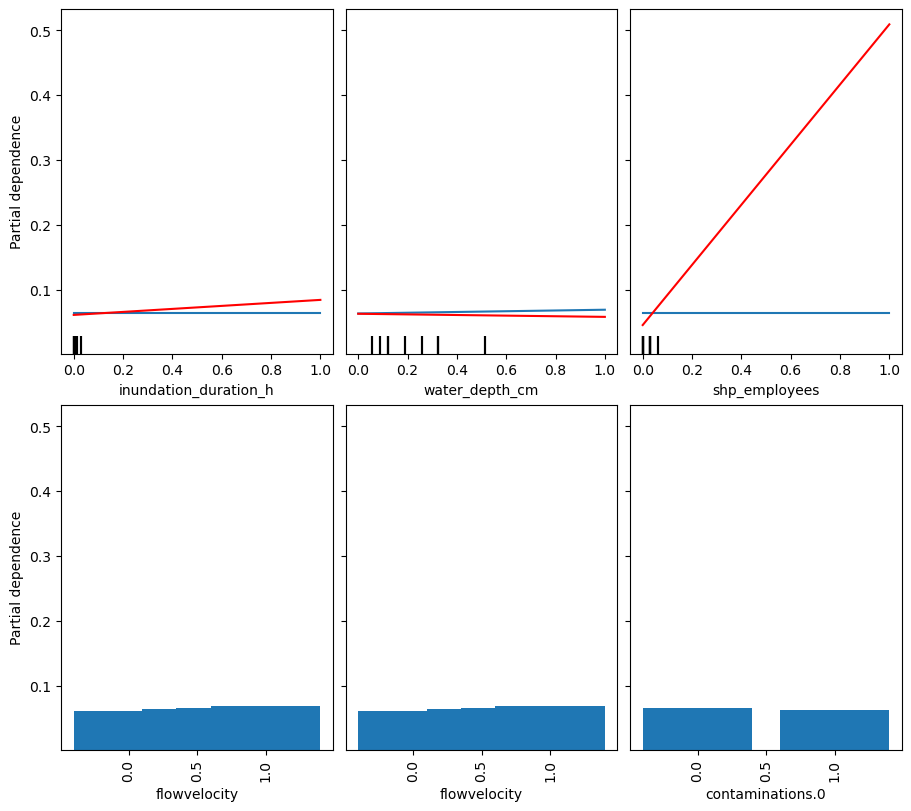

In [113]:

categorical_features = ["flowvelocity", "contaminations.0"]

features_info = {
    # features of interest (numerical + categorical features)
    "features": ["inundation_duration_h", "water_depth_cm",	"shp_employees","flowvelocity", "flowvelocity", "contaminations.0"],
    # type of partial dependence plot
    "kind": "average",  # PDP
    #"kind": "both",   # PDP with ICE indiv Effectiveness
    #"centered": True,
    # information regarding categorical features
    "categorical_features": categorical_features,
}
common_params = {
    #"subsample": 50,
    #"n_jobs": 2,
   # "grid_resolution": 20,
    "random_state": seed,
}

_, ax = plt.subplots(ncols=3, nrows=2, figsize=(9, 8), constrained_layout=True)
en_pdp = PartialDependenceDisplay.from_estimator(
    models_trained["trained_en"],
    pd.DataFrame(X, columns=X_unscaled.columns),  # X_train
    **features_info,
    ax=ax,
    **common_params,
)
xgb_pdp = PartialDependenceDisplay.from_estimator(
    models_trained["trained_xgb"],
    pd.DataFrame(X, columns=X_unscaled.columns),  # X_train
    **features_info,
    ax=ax, 
    line_kw={"color": "red"},
    **common_params
)
crf_pdp = PartialDependenceDisplay.from_estimator(
    model,
    #models_trained["trained_crf"],
    pd.DataFrame(X, columns=X_unscaled.columns),  # X_train
    **features_info,
    ax=ax, 
    line_kw={"color": "green"},
    **common_params
)
_ = display.figure_.suptitle(
    (
        "Partial dependence of the number of bike rentals\n"
        "for the bike rental dataset with an MLPRegressor"
    ),
    fontsize=16,
)
#plt.set_ylim(0,3)
plt.show()

# partial_dependence(models_trained["trained_en"], features=[0], X=X, percentiles=(0, 1),
#                     grid_resolution=2) 

# tree_disp.plot(line_kw={"label": "Decision Tree"})
# mlp_disp.plot(
#     line_kw={"label": "Multi-layer Perceptron", "color": "red"}, ax=tree_disp.axes_
# )
#tree_disp.figure_.set_size_inches(10, 6)

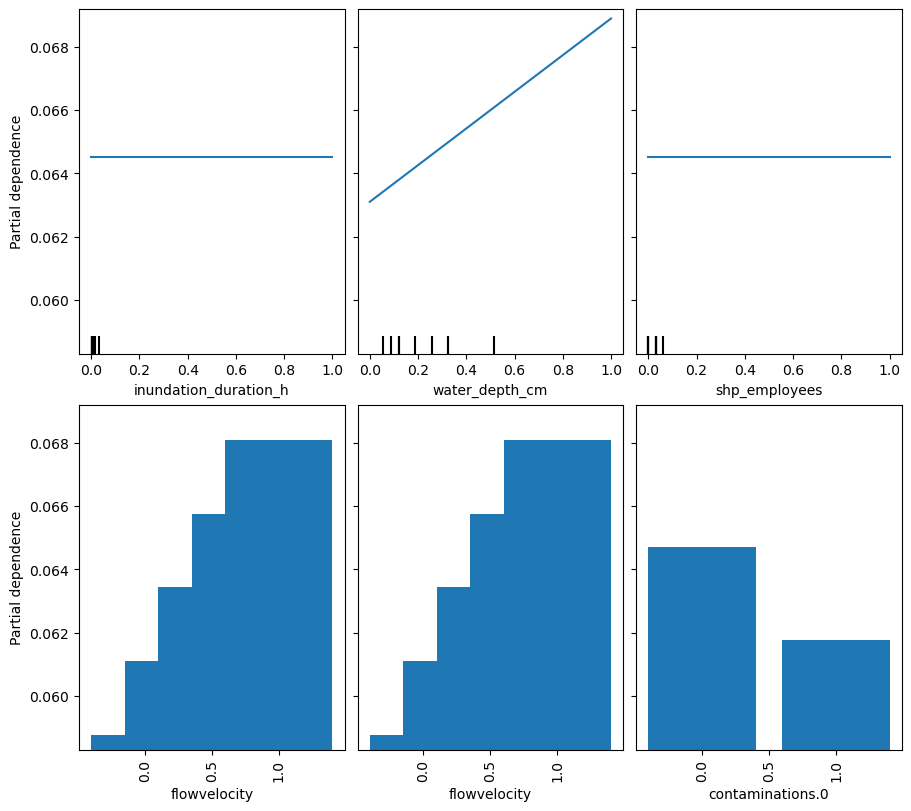

In [95]:
# ## func partial dep figures
features = X_unscaled.columns


features_info = {
    # features of interest (numerical + categorical features)
    "features": ["inundation_duration_h", "water_depth_cm",	"shp_employees","flowvelocity", "flowvelocity", "contaminations.0"],
    # type of partial dependence plot
    "kind": "average",  # PDP
    #"kind": "both",   # PDP with ICE indiv Effectiveness
    #"centered": True,
    # information regarding categorical features
    "categorical_features": categorical_features,
}

#tree_disp = PartialDependenceDisplay.from_estimator(tree, X, ["age", "bmi"], ax=ax)
categorical_features = ["flowvelocity", "contaminations.0"]

_, ax = plt.subplots(ncols=3, nrows=2, figsize=(9, 8), constrained_layout=True)

# xgb_pdp = PartialDependenceDisplay.from_estimator(
#     models_trained["trained_xgb"], 
#     pd.DataFrame(X, columns=X_unscaled.columns), 
#     ["inundation_duration_h"]
# )
models_partialdependencies = PartialDependenceDisplay.from_estimator(
    models_trained["trained_en"], 
    pd.DataFrame(X, columns=X_unscaled.columns), 
    **features_info,
    ax=ax,
    #**common_params,
)

_ = display.figure_.suptitle(
    (
        "Partial dependence of the number of bike rentals\n"
    ),
    fontsize=16,
)
#en_pdp = PartialDependenceDisplay.from_estimator(models_trained["trained_en"], X, ["inundation_duration_h"])
# en_disp = PartialDependenceDisplay.from_estimator(
#     models_trained["trained_en"], X, ["age"], ax=tree_disp.axes_, line_kw={"color": "red"}
# )
#xgb_pdp.plot(line_kw={"label": "Decision Tree"})

# print("Computing partial dependence plots...")

# models_partialdependencies.plot(
#     line_kw={"label": "Multi-layer Perceptron", "color": "red"}, ax=xgb_pdp.axes_
# )
# xgb_pdp.figure_.set_size_inches(10, 6)
# xgb_pdp.axes_[0, 0].legend()
# # xgb_pdp.axes_[0, 1].legend()
# plt.show()

# partial_dependence(models_trained["trained_en"], features=[0], X=X, percentiles=(0, 1),
#                     grid_resolution=2) 


# fig = plot_partial_dependence(
#     model, X=X_train, features=features, n_jobs=5, grid_resolution=50#, fig=fig
# ) #, feature_names
# plt.subplots_adjust(top=1.2)
# plt.savefig(outfile, bbox_inches="tight")

In [ ]:
#def plot_partial_dependencies(model, X_train, outfile):
    # """
    # Creates plots for partial dependecies
    # :param model: Model instance
    # :param X_train: 
    # :param feature_names: List of features
    # :param outfile: Path to output file
    # :return:
    # """
features = X.columns
fig = f.plot_partial_dependencea(
    model, X=Xn, features=features, n_jobs=5, grid_resolution=50#, fig=fig
) #, feature_names
plt.subplots_adjust(top=1.2)
#plt.savefig(outfile, bbox_inches="tight")
plt.close()


### Empirical median ~ predicted median

And further statitics compared to their empirical counterpart.
-  mean /variance / std  compared to empirical distribution

In [ ]:
#model.predict()


In [24]:
print("Testing models for : ", target)
e.empirical_vs_predicted(
    X, y,
    models_list = [models_trained["trained_crf"], models_trained["trained_xgb"]]#, models_trained["trained_en"]] 
    #models_trained#[f"trained_{model_name}_cv"]
    #models_list=[model, model_log, model_quantile, model_boxcox, model_sqrt]    
)

## TODO fix y empirical
# ## TODO idea: make a median/mean etc of best model as boxplots 8one (3 models for each target)


Testing models for :  Target_relative_contentloss_euro


AttributeError: 'ListVector' object has no attribute 'predict'

In [107]:
# print(target)
# print(X.shape)

# df_importance

Target_relative_contentloss_euro
(133, 27)


,importances
shp_registered_capital_euro,0.156041
shp_employees,0.146143
contaminations.0,0.027468
water_barriers_impl,0.024416
flood_experience,0.024315
emergency_measures.4,0.023024
shp_sector,0.011757
b_area,0.010517
electricity_higher_impl,0.009988
bage,0.009262


In [75]:
print("median entire ds")
print(np.median(y))
#print(np.median(model.predict(X)))
y_pred = model
print(np.median([outer_y_pred[{model_name}]]))

print("mean entire ds")
print(np.mean(y))
#print(np.mean(model.predict(X)))
y_pred = model
print(np.mean([outer_y_pred[{model_name}]]))


median entire ds
0.01000119482099409
0.04939702
mean entire ds
0.056081992063753514
0.060931973


In [15]:
# importances = e.permutation_feature_importance(model, X_test, y_test, repeats=5, seed=seed)

# df_importance = pd.DataFrame(
#     {"importances" : importances[0]},
#     index=X_train.columns.to_list(),
#     ) 
# df_importance = df_importance.sort_values("importances", ascending=False)  # get most important features to the top
# print("Most important features:", df_importance.iloc[:5].index.to_list())
# #df_importance = df_importance.loc[df_importance.importances >= 0.000000, : ]

# df_importance

In [16]:
model_cv.best_params_

y_train

##  MAE: + in target unit +  less likely to be affected by extreme values.
## MAPE: r (MAPE) quantifies the average absolute difference between 
## the anticipated and observed values of the target variable as a percentage of the observed value. 
## The method works well for assessing models where the target variable spans a broad range of scales

# 75 % in train mit 300 trress, subsam0.8, maxdep=3, aber bad teest R2


## R²-Score: 0.46
# {'model__validate_parameters': True,
#  'model__n_estimators': 800,
#  'model__max_depth': 10,
#  'model__eta': 0.2}


95      36.8
273    621.3
182    186.8
152     37.4
147    560.5
       ...  
185     44.7
275     39.7
40     644.3
234    382.7
268    223.4
Name: Target_contentloss_euro, Length: 132, dtype: float64

In [17]:
## reload models

# fi_cols =  df_importance.loc[df_importance.importances >= 0.0000001 , : ].index.to_list()#.shape
# print(len(fi_cols))
# print(fi_cols)

# # model_cv = RandomizedSearchCV(
# #     estimator=XGBRegressor(), 
# #     param_distributions=param_grid, #
# #     #param_distributions=param_bag_grid, 
# #     cv=cv, 
# #     scoring= "neg_mean_absolute_error",##"neg_mean_absolute_error", #"neg_mean_squared_error",#"r2" ,#"neg_mean_absolute_error",   #TODO classifcation: test also e.g "f1" or recall or "f1_micro", "neg_mean_absolute_error",
# #     refit=False,   ## Refit the best estimator with the entire dataset. If “False”, it is impossible to make predictions using this GridSearchCV instance after fitting.
# #                     ## If refit=False, clf.fit() will have no effect because the GridSearchCV object inside the pipeline will be reinitialized after fit().
# #                     ## ! When refit=True, the GridSearchCV will be refitted with the best scoring parameter combination on the whole data that is passed in fit()
# #     random_state=seed
# # )
# # Fit model
# #model =XGBRegressor()# model_cv.best_estimator_
# model.fit(X_train.loc[:, fi_cols], y_train)   

# #print('Train R^2 Score : %.3f'%model_cv.best_estimator_.score(X_train.loc[:, fi_cols], y_train))
# #print('Test R^2 Score : %.3f'%model_cv.best_estimator_.score(X_test.loc[:, fi_cols], y_test))
# #print("CV score: ", model_cv.best_score_ ,  model_cv.best_estimator_.score(X_train, y_train),  model_cv.best_estimator_.score(X_test, y_test))
# ## Evaluate
# ## print evaluation report + check for overfitting 
# print("\nTraining set")
# y_pred_train = model.predict(X_train.loc[:, fi_cols])
# #y_pred_train = model_cv.best_estimator_.predict(X_train)
# e.evaluation_report(y_train, y_pred_train)

# print("\nTesting set")
# #y_pred = model_cv.best_estimator_.predict(X_test)
# y_pred = model.predict(X_test.loc[:, fi_cols])
# e.evaluation_report(y_test, y_pred)


In [18]:


##pipelines = ["pipe_bag_en"]#, 
pipelines = ["pipe_en" ]#
pipe_name = pipelines[0]

#model_eval = pickle.load(open(f"./models_trained/best_elasticnet_{target}_{pipe_name}.sav", 'rb'))
#elastic_net_eval.get_params()



In [19]:
print('R^2 training set', round(model.score(X_train, y_train)*100, 2), ' %')
print('R^2 test set', round(model.score(X_test, y_test)*100, 2))

learning_rate = [0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]



## Plot tagret vs its log-transformed version

## Plot tagret vs its log-transformed version

R^2 training set 97.9  %
R^2 test set -49.21


In [20]:
## Plot learning rate see if    
means = model_cv.cv_results_['mean_test_score']
stds = model_cv.cv_results_['std_test_score']
params = model_cv.cv_results_['params']

# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

# plot results
# scores = np.array(means).reshape(len(learning_rate), len(n_estimators))
# for i, value in enumerate(learning_rate):
#     plt.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
# for mean, stdev, param in zip(means, stds, params):
# 	print("%f (%f) with: %r" % (mean, stdev, param))
# plot
#plt.use('Agg')
import matplotlib
matplotlib.use('Agg')


plt.errorbar(learning_rate, means, yerr=stds)
plt.legend()
plt.xlabel('learning_rate')
plt.ylabel('Log Loss')
plt.savefig('log_loss_vs_learning_rate.png')
plt.show()
# scores = np.array(means).reshape(len(learning_rate), len(n_estimators))
# for i, value in enumerate(learning_rate):
#     plt.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
# plt.legend()
# plt.xlabel('learning_rate')
# plt.ylabel('Log Loss')
# plt.savefig('n_estimators_vs_learning_rate.png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [21]:
#plt.savefig(f"./models_trained/FI_{target}.png", bbox_inches='tight')
#sns_plot.figure.savefig("output.png")
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))


0.9790346135872993
-0.4921255591097222


### Plot prediction error 

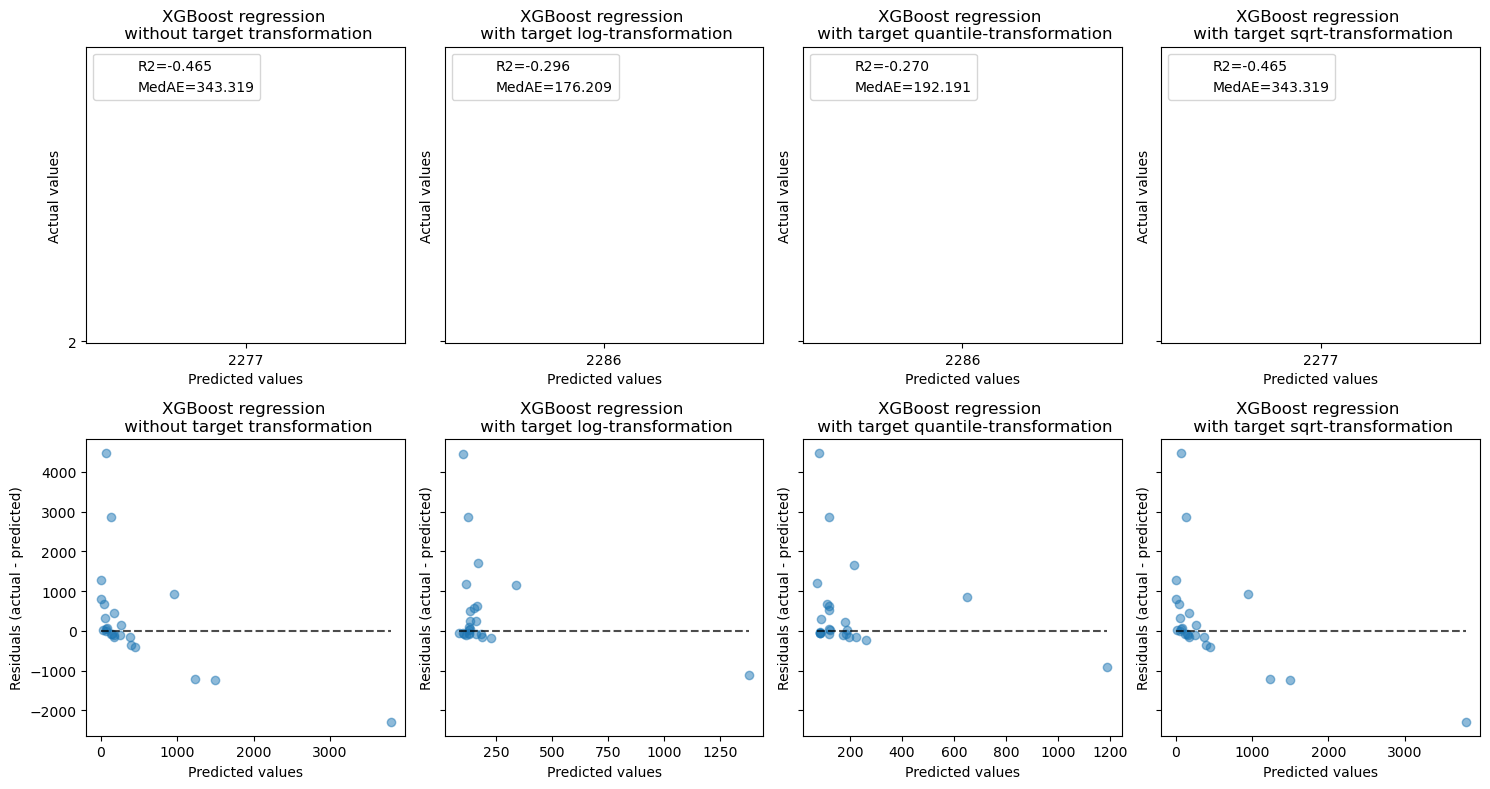

In [63]:
#y_pred_log_train = model_log.predict(X_train)
y_pred = model.predict(X_test)
y_pred_log = model_log.predict(X_test)
y_pred_quantile = model_quantile.predict(X_test)
#y_pred_boxcox = model_boxcox.predict(X_test)
y_pred_sqrt = model_sqrt.predict(X_test)


f, (ax0, ax1) = plt.subplots( 2, 4,  sharey="row", figsize=(15, 8)) # 

PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred,
    kind="actual_vs_predicted",
    ax=ax0[0],
    scatter_kwargs={"alpha": 0.5},
)
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_log,
    kind="actual_vs_predicted",
    ax=ax0[1],
    scatter_kwargs={"alpha": 0.5},
)
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_quantile,
    kind="actual_vs_predicted",
    ax=ax0[2],
    scatter_kwargs={"alpha": 0.5},
)
# PredictionErrorDisplay.from_predictions(
#     y_test,
#     y_pred_boxcox,
#     kind="actual_vs_predicted",
#     ax=ax0[3],
#     scatter_kwargs={"alpha": 0.5},
# )
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_sqrt,
    kind="actual_vs_predicted",
    ax=ax0[3],
    scatter_kwargs={"alpha": 0.5},
)
ax0[0].set_title("XGBoost regression \n without target transformation")
ax0[1].set_title("XGBoost regression \n with target log-transformation")
ax0[2].set_title("XGBoost regression \n with target quantile-transformation")
ax0[3].set_title("XGBoost regression \n with target sqrt-transformation")
#ax0[3].set_title("XGBoost regression \n with target boxcox-transformation")

ax0[0].set_ylim(0, 300)


# Add the score in the legend of each axis
for ax, y_pred in zip([ax0[0], ax0[1], ax0[2],ax0[3]], [y_pred, y_pred_log, y_pred_quantile, y_pred_sqrt]):
#for ax, y_pred in zip([ax0[0], ax0[1], ax0[2],ax0[3]], [y_pred, y_pred_log, y_pred_quantile, y_pred_boxcox]):
    for name, score in e.compute_score(y_test, y_pred).items():
        ax.plot([], [], " ", label=f"{name}={score}")
    ax.legend(loc="upper left")


# plot the residuals vs the predicted values
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred,
    kind="residual_vs_predicted",
    ax=ax1[0],
    scatter_kwargs={"alpha": 0.5},
)
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_log,
    kind="residual_vs_predicted",
    ax=ax1[1],
    scatter_kwargs={"alpha": 0.5},
)
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_quantile,
    kind="residual_vs_predicted",
    ax=ax1[2],
    scatter_kwargs={"alpha": 0.5},
)
# PredictionErrorDisplay.from_predictions(
#     y_test,
#     y_pred_boxcox,
#     kind="residual_vs_predicted",
#     ax=ax1[3],
#     scatter_kwargs={"alpha": 0.5},
# )
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_sqrt,
    kind="residual_vs_predicted",
    ax=ax1[3],
    scatter_kwargs={"alpha": 0.5},
)
ax1[0].set_title("XGBoost regression \n without target transformation")
ax1[1].set_title("XGBoost regression \n with target log-transformation")
ax1[2].set_title("XGBoost regression \n with target quantile-transformation")
#ax1[3].set_title("XGBoost regression \n with target boxcox-transformation")
ax1[3].set_title("XGBoost regression \n with target sqrt-transformation")

#ax1[0].set_ylim(0,200)


#f.suptitle("Synthetic data", y=1.05)
plt.tight_layout()


## reload models


#model_eval = pickle.load(open(f"./models_trained/xgboost_{target}_{pipe_name}.sav", 'rb'))
#model_eval.get_params()
#dir(model_eval)#.feature_importances_[model_eval.feature_importances_>0.015].shape

## left overs

### outdated -Feature importance
Have the same feature importance method across all applied ML models


In [24]:

# df_importance_package = pd.DataFrame({
#     "name" : X_train.columns.to_list(),
#     "importances" : model.feature_importances_,
#      }) 
# df_importance_package.sort_values("importances", ascending=False)[:10]

In [25]:
# ## Permuation feature importance
# result = e.permutation_feature_importance(model, X_test, y_test, repeats=5, seed=seed)

# df_importance = pd.DataFrame({
#     "name" : X_train.columns.to_list(),
#     "importances" : result[0],
# #    "importances" : np.abs(result[0]),
#      }) 
# df_importance = df_importance.sort_values("importances", ascending=True)  # get most important features to the top
# df_importance.tail(18)

### plot feature importance


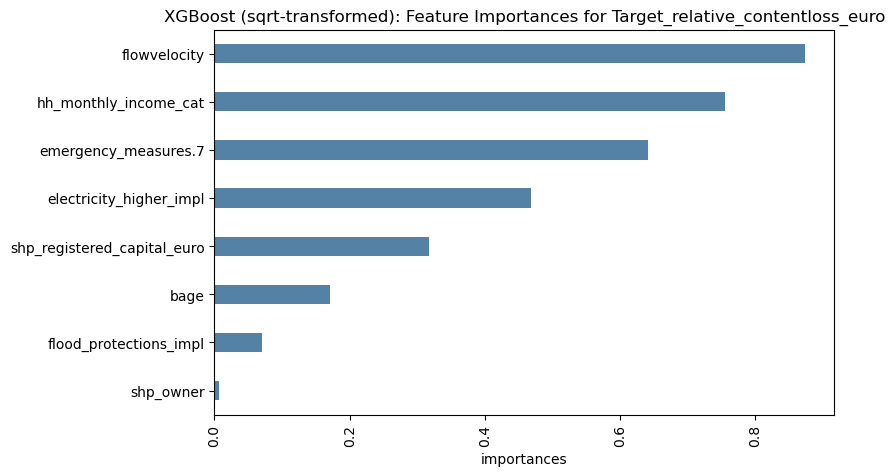

In [86]:
# # reload evalation set
# eval_set = eval_set_list[0]#[pipe_name]


# importances = e.permutation_feature_importance(model_sqrt, 
# #importances = e.permutation_feature_importance(model, 
#                                                X_test,
#                                                y_test,
#                                                #eval_set.drop(target, axis=1), 
#                                                #eval_set[target], 
#                                                repeats=5, seed=seed
#                                                )

# ## feature importance scores
# df_importance = pd.DataFrame({
#     "name" : X_unscaled.columns.to_list(),
#     "importances" : importances[0],
#      }) 

# # drop features which dont reduce the loss
# df_importance = df_importance.loc[df_importance.importances > 0.0000, : ] 
# df_importance = df_importance.sort_values("importances", ascending=False)


# #fig, ax = plt.subplots(figsize=(12,5))
# plt.figure(figsize=(8, 5))
# #plt.barh(df_importance.name, df_importance.importances)
# #plt.barh(df_importance.name[-18:], df_importance.importances[-18:])

# sns.barplot(
#     data=df_importance, 
#     x="importances", y="name",
#     width=0.4,
#     color='steelblue',
#     #errorbar="sd",
#     errorbar=("pi", 50), 
#     capsize=.1, errcolor=".5",
#     linewidth=3, #edgecolor=".3", #facecolor=(0,0,0,0),
# )
# plt.ylabel("")
# plt.xticks(
#     rotation = 90
#     )
# plt.title(f"XGBoost (sqrt-transformed): Feature Importances for {target}")
# plt.show()

# ## save importnace scores  and figure
# #filepath = f'./models_evaluation/best_xgb_importance_scores_{target}_{pipe_name}'
# #if not glob(filepath):
# #    df_importance.to_csv(filename, index = False)


# #plt.savefig(f'../../../figures/best_en_feature_importance_{target}_{pipe_name}.png', bbox_inches='tight')





### partial dependencies

In [ ]:
# fig, ax = plt.subplots(figsize=(12, 6))
# ax.set_title("Decision Tree")
# tree_disp = PartialDependenceDisplay.from_estimator(models_trained["trained_xgb"], pd.DataFrame(X, columns=X_unscaled.columns), ["shp_employees"], ax=ax)
#tree_disp = PartialDependenceDisplay.from_estimator(model, pd.DataFrame(X, columns=X_unscaled.columns), ["shp_employees"], ax=ax)

tree_disp = PartialDependenceDisplay.from_estimator(models_trained["trained_en"], pd.DataFrame(X, columns=X_unscaled.columns), ["shp_employees"])
mlp_disp = PartialDependenceDisplay.from_estimator(
    models_trained["trained_xgb"], pd.DataFrame(X, columns=X_unscaled.columns), ["shp_employees"], ax=tree_disp.axes_, line_kw={"color": "red"}
)

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
# tree_disp.plot(ax=[ax1, ax2], line_kw={"label": "Decision Tree"})
# tree_disp.plot(
#     ax=[ax1, ax2], line_kw={"label": "Multi-layer Perceptron", "color": "red"}
# )
# ax1.legend()
# ax2.legend()

##### Hierarchical clustering on Spearman rank correlation

Select only feautres with low collienarity to solve disadvantage of perumation feature importance.
Randomizing one feature would lead to only small importance score - the model performance wouldnt be move influenced - due that the information is included in other correlated features. Removing one feature keeps the similar inforamtion in the other feautres unchanged and the model learns from the correlated feature. Therefore apply hierachical clustering to select less correlated features

See also:
- Brill 2020 (dissertation)
- https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html # code example
- https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py # code example

In [ ]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr

fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(df_candidates).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=df_candidates.columns.to_list(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

# ax1.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
# ax1.set_xticks(dendro_idx)
# ax1.set_yticks(dendro_idx)
# ax1.set_xticklabels(dendro["ivl"], rotation="vertical")
# ax1.set_yticklabels(dendro["ivl"])
# _ = fig.tight_layout()


In [ ]:
# import scipy.cluster.hierarchy as shc

# plt.figure(figsize=(15, 10))
# plt.title("Customers Dendrogram")

# # Selecting Annual Income and Spending Scores by index
# selected_data = X_train.dropna()
# selected_data = selected_data.T # only possible with out nan
# clusters = shc.linkage(selected_data, 
#             method='ward', optimal_ordering=False,
#             metric="euclidean")
# shc.dendrogram(Z=clusters, 
#                #p=20, # p -> value for truncation mode
#                orientation="right",
#                labels=X_train.columns
#                ) 
# plt.show()

# ## TODO adapt with spearman rank order



In [ ]:

# from scipy.stats import spearmanr
# from scipy.spatial.distance import squareform
# from scipy.cluster.hierarchy import ward, dendrogram

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
# corr = spearmanr(X_unscaled_no_nan).correlation

# # Ensure the correlation matrix is symmetric
# corr = (corr + corr.T) / 2
# np.fill_diagonal(corr, 1)

# # We convert the correlation matrix to a distance matrix before performing
# # hierarchical clustering using Ward's linkage.
# distance_matrix = 1 - np.abs(corr)
# dist_linkage = ward(distance_matrix, checks=False )
# dendro = dendrogram(
#     dist_linkage, labels=X_unscaled_no_nan.columns.tolist(), ax=ax1, leaf_rotation=90
# )
# dendro_idx = np.arange(0, len(dendro["ivl"]))

# ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
# ax2.set_xticks(dendro_idx)
# ax2.set_yticks(dendro_idx)
# ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
# ax2.set_yticklabels(dendro["ivl"])
# fig.tight_layout()

# cluster_ids = shc.fcluster(dist_linkage, 1, criterion="distance")
# cluster_id_to_feature_ids = defaultdict(list)
# for idx, cluster_id in enumerate(cluster_ids):
#     cluster_id_to_feature_ids[cluster_id].append(idx)
# selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

# X_train_sel = X_train[:, selected_features]
# X_test_sel = X_test[:, selected_features]



In [ ]:
# closs hyperapram , no model__early_stopping_rounds, repeatedcv wit h10 folds
## best train R2: ntree=30, max_depth =1, no furhter params

# learning_rate = [ 0.00001, 0.0001, 0.001, 0.1, 0.2]#, 0.3, 0.4, 0.5, 0.6, 0.8, 0.9] # store outside, for plotting
# n_estimators = [ 50, 100, 200, 300, 500, 800]

# param_grid = {'model__n_estimators': n_estimators,
#     #'model__n_estimators': [ 3, 5, 10, 20], # get only low train scores with this
#               'model__max_depth': [1, 2, 3, 5, 7, 8, 10, 15],
#               #'model__max_leaves': [0, 3, 5],
#              # 'model__colsample_bytree': [ 0.3, 0.5, 0.7, 1.0 ], # Percentage of columns to be randomly samples for each tree
#              # 'model__colsample_bynode': [ 0.3, 0.5, 0.7, 1.0], # nbr of feautres for each split point
#              # 'model__eta': learning_rate,  # == eta
#             #   'model__gamma': [0.2, 0.3, 0.5, 0.8, 1, 3] , # min_split_loss -  larger gamma is, the more conservative the algorithm is
#               'model__subsample': [0.0, 0.2, 0.5, 0.6, 0.8, 0.9],  # define subsample of train st prior to growing trees, prevent overfitting
#             #  'model__reg_alpha': [0.5, 1.0, 2.0, 4.0, 5.0, 6.0 ,7.0],   # Lasso Regularization term on weights , higher values = more consrvative 
#             #  'model__reg_lambda': [0.0, 0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0],  # Ridge Regularization term on weights ,  higher values = more consrvative
#             #   'model__min_child_weight': [0, 1, 2, 3, 4,],
#             #   "model__max_delta_step":  [0, 3, 5, 6, 7],           # for LogisticReg good to solve imbalance 
#           #   'model__objective': [None, 'reg:absoluteerror'],#'multi:softprob,'reg:squarederror','reg:models_trained'],
#           #  # 'model__tree_method': ["hist", "gpu_hist"],
#           #   'model__booster': [None, "gblinear", "gbtree"],
#             "model__validate_parameters":[True],
#               }

# # 'model__scale_pos_weight': [0.0, 0.3, 0.5, 0.7, 0.9, 1.0],  # only  for clasifcation: handle imbalance, ratio between negative and positive examples

# # Objective candidate: multi:softmax
# # Objective candidate: multi:softprob
# # Objective candidate: reg:squarederror
# # Objective candidate: reg:squaredlogerror
# # Objective candidate: reg:logistic
# ## Objective candidate: reg:linear
# # Objective candidate: reg:pseudohubererror
# # Objective candidate: reg:gamma
# # Objective candidate: reg:absoluteerror

# ## DOC: https://xgboost.readthedocs.io/en/stable/parameter.html
